
# Previsão de `IPG2211A2N` a partir de `DATE`

Este notebook utiliza o dataset `Electric_Production.csv` (colunas padrão do FRED: `DATE`, `IPG2211A2N`).  
Objetivos:
- **Evitar data leakage** via separação temporal estrita (treino / validação / teste).
- **Treinar e avaliar** um modelo de previsão de série temporal.

> Observação: ajuste o caminho do dataset em `DATA_PATH` se necessário.  
> Dataset padrão esperado aqui: `/mnt/data/Electric_Production.csv`.

Divisão sugerida:
- **Treino**: todo o histórico exceto os últimos 48 meses
- **Validação**: penúltimos 24 meses (para ajuste/early stopping)
- **Teste**: últimos 24 meses (avaliação final)


---

# Modelo 2 — Prophet

## Estratégia de Split (sem vazamento de dados)

- A divisão é **temporal**: treino → validação → teste (nesse ordem).
- Transformações como **padronização/normalização** são **ajustadas apenas no conjunto de treino** e aplicadas a val/test.
- Para janelas (LSTM), as sequências de validação/teste **usam apenas contexto passado** (incluindo o final do treino), nunca valores futuros do período avaliado.


In [1]:

# %% Imports e configuração
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Instale localmente se necessário:
# !pip install prophet -q

try:
    from prophet import Prophet
except Exception:
    # fallback para fbprophet caso esteja com o nome antigo
    from fbprophet import Prophet

from sklearn.metrics import mean_absolute_error, mean_squared_error

DATA_PATH = r"Electric_Production.csv"  # ajuste se necessário


/Users/pedromoritabannwart/Code/inteli/LSTM/Ponderada-LSTM-SEMANA9/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:

# %% Carregar dados
df = pd.read_csv(DATA_PATH)
if "DATE" not in df.columns or "IPG2211A2N" not in df.columns:
    raise ValueError("O CSV deve conter as colunas 'DATE' e 'IPG2211A2N'.")

df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE").reset_index(drop=True)

# Frequência mensal contínua
ts = (df.set_index("DATE")[["IPG2211A2N"]]
        .asfreq("MS"))
if ts["IPG2211A2N"].isna().any():
    ts["IPG2211A2N"] = ts["IPG2211A2N"].interpolate(limit_direction="both")

df = ts.reset_index().rename(columns={"DATE": "ds", "IPG2211A2N": "y"})
df.head()


,ds,y
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


In [3]:
# %% Split temporal por proporção (80/10/10) usando sklearn, sem shuffle (sem vazamento)
from sklearn.model_selection import train_test_split

# garanta que está ordenado por data
df = df.sort_values("ds").reset_index(drop=True)

TRAIN_RATIO = 0.80
VAL_RATIO   = 0.10
TEST_RATIO  = 0.10
assert abs(TRAIN_RATIO + VAL_RATIO + TEST_RATIO - 1.0) < 1e-9

# 1) train vs temp (val+test)
df_train, df_temp = train_test_split(
    df,
    test_size=VAL_RATIO + TEST_RATIO,
    shuffle=False
)

# 2) temp -> val vs test (mantendo ordem)
# fração do test dentro de (val+test)
rel_test = TEST_RATIO / (VAL_RATIO + TEST_RATIO)

df_val, df_test = train_test_split(
    df_temp,
    test_size=rel_test,
    shuffle=False
)

train, val, test = df_train.copy(), df_val.copy(), df_test.copy()

print("Tamanhos:", len(train), len(val), len(test))
display(train.tail(3)); display(val.head(3)); display(test.head(3))

# sanity checks de ordem temporal
assert train["ds"].max() < val["ds"].min() <= val["ds"].max() < test["ds"].min(), "Verifique a ordem das datas"


Tamanhos: 317 40 40


,ds,y
314,2011-03-01,99.1028
315,2011-04-01,89.3583
316,2011-05-01,90.0698


,ds,y
317,2011-06-01,102.8204
318,2011-07-01,114.7068
319,2011-08-01,113.5958


,ds,y
357,2014-10-01,92.3837
358,2014-11-01,99.7033
359,2014-12-01,109.3477


10:18:51 - cmdstanpy - INFO - Chain [1] start processing
10:18:52 - cmdstanpy - INFO - Chain [1] done processing


VALIDAÇÃO -> RMSE: 3.6593 | MAE: 2.7781 | MAPE: 2.71%
TESTE -> RMSE: 4.5182 | MAE: 3.6139 | MAPE: 3.54%


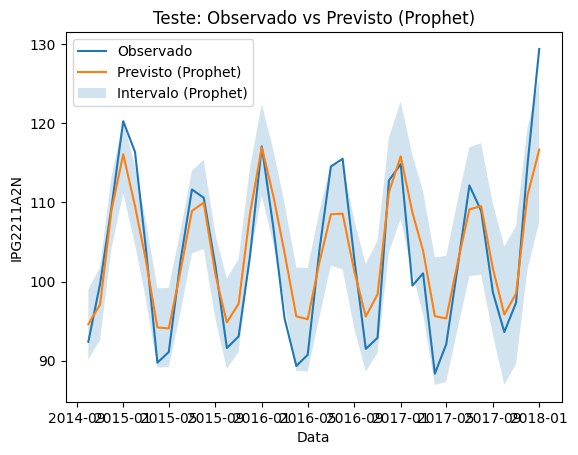

,ds,y,yhat,yhat_lower,yhat_upper
35,2017-09-01,98.6154,101.626833,93.249473,109.805476
36,2017-10-01,93.6137,95.825596,86.961600,104.439762
37,2017-11-01,97.3359,98.475391,89.562143,107.022386
38,2017-12-01,114.7212,110.869396,101.502386,119.450958
39,2018-01-01,129.4048,116.679421,107.547633,125.550317


In [4]:
# %% Treino e Avaliação do Prophet (sem vazamento) — BLOCO COMPLETO
import numpy as np
import matplotlib.pyplot as plt
import inspect
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Treino do Prophet (apenas em TREINO para evitar vazamento)
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode="additive",
    changepoint_prior_scale=0.5
)
m.fit(train[["ds","y"]])

# --- Previsão para Validação + Teste (futuro a partir do fim do treino)
future = m.make_future_dataframe(
    periods=len(val) + len(test),
    freq="MS",
    include_history=True
)
fcst = m.predict(future)

# --- Selecionar as janelas de Val e Teste
fcst_val  = fcst[fcst["ds"].between(val["ds"].min(),  val["ds"].max())][["ds","yhat","yhat_lower","yhat_upper"]]
fcst_test = fcst[fcst["ds"].between(test["ds"].min(), test["ds"].max())][["ds","yhat","yhat_lower","yhat_upper"]]

# --- Funções de métricas (compatível com versões antigas do scikit-learn)
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def rmse_safe(y_true, y_pred):
    # usa squared=False se disponível; caso contrário, sqrt do MSE
    has_squared = "squared" in inspect.signature(mean_squared_error).parameters
    if has_squared:
        return mean_squared_error(y_true, y_pred, squared=False)
    else:
        return np.sqrt(mean_squared_error(y_true, y_pred))

# --- Avaliação em Validação
val_eval = val.merge(fcst_val, on="ds", how="left")
rmse_val = rmse_safe(val_eval["y"], val_eval["yhat"])
mae_val  = mean_absolute_error(val_eval["y"], val_eval["yhat"])
mape_val = mape(val_eval["y"], val_eval["yhat"])
print(f"VALIDAÇÃO -> RMSE: {rmse_val:.4f} | MAE: {mae_val:.4f} | MAPE: {mape_val:.2f}%")

# --- Avaliação em Teste
test_eval = test.merge(fcst_test, on="ds", how="left")
rmse_test = rmse_safe(test_eval["y"], test_eval["yhat"])
mae_test  = mean_absolute_error(test_eval["y"], test_eval["yhat"])
mape_test = mape(test_eval["y"], test_eval["yhat"])
print(f"TESTE -> RMSE: {rmse_test:.4f} | MAE: {mae_test:.4f} | MAPE: {mape_test:.2f}%")

# --- Plot (Teste): Observado vs Previsto + Intervalo
plt.figure()
plt.plot(test_eval["ds"], test_eval["y"], label="Observado")
plt.plot(test_eval["ds"], test_eval["yhat"], label="Previsto (Prophet)")
plt.fill_between(
    test_eval["ds"].values,
    test_eval["yhat_lower"].values,
    test_eval["yhat_upper"].values,
    alpha=0.2,
    label="Intervalo (Prophet)"
)
plt.title("Teste: Observado vs Previsto (Prophet)")
plt.xlabel("Data"); plt.ylabel("IPG2211A2N")
plt.legend()
plt.show()

# Mostra as últimas linhas para inspeção rápida
test_eval.tail()



## Métricas
- **RMSE**
- **MAE**
- **MAPE** (ignora valores 0)


## Gráfico
O gráfico compara **observado vs. previsto** no período de teste.
